<a href="https://colab.research.google.com/github/SebGonS/TF-Machine-Learning/blob/main/TF_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN

In [ ]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
torch.manual_seed(0)

## Parametros
 - batch_size: número de ejemplos de entrenamiento usados en una iteración
 - num_channels: número de canales en un punto de datos (rgb usaria 3, en nuestro caso se usa 32) ya que se esta representado el objeto 3D como una imagen 2d de 32 canales
 - num classes: cantidad de tipos de datos distintos, en nuestro caso al tratarse de un solo objeto (mesa) se toma 1

# Datos

In [ ]:
dataset= np.load("dataset_table_gan.npy", allow_pickle=True).item()

In [ ]:
print(dataset.keys())

dict_keys(['train', 'test'])


In [ ]:
print(dataset["train"].keys())

dict_keys(['disc', 'frag'])


In [ ]:
disc_train=dataset["train"]["disc"] #mesas enteras
frag_train=np.array(dataset["train"]["frag"]) #mesas fragmentadas

In [ ]:
disc_train.shape

(392, 32, 32, 32)

In [ ]:
frag_train.shape

(392, 32, 32, 32)

In [ ]:
disc_train=disc_train.astype(float)
frag_train=frag_train.astype(float)

In [ ]:
train_frag = [torch.from_numpy(np.array([obj])*2-1).to(device) for obj in disc_train]
train_real = [torch.from_numpy(np.array([obj])*2-1).to(device) for obj in frag_train]

In [ ]:
dataloader = DataLoader(list(zip(train_frag, train_real)), batch_size=batch_size, shuffle=True)


None


In [ ]:
Dataset=dataloader.dataset

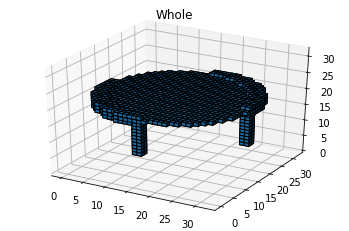

In [ ]:
ax = plt.figure().add_subplot(projection='3d')
plt.title("Whole")
ax.voxels(disc_train[0], edgecolor='k')
plt.show()

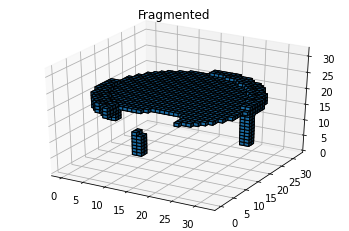

In [ ]:
ax = plt.figure().add_subplot(projection='3d')
plt.title("Fragmented")
ax.voxels(frag_train[0], edgecolor='k')
plt.show()

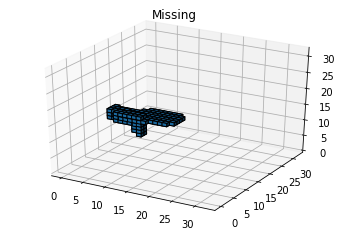

In [ ]:
ax = plt.figure().add_subplot(projection='3d')
plt.title("Missing")
ax.voxels(disc_train[0]-frag_train[0], edgecolor='k')
plt.show()

# Modelo

Parametros

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available()

batch_size = 40

workers = 32

image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 32

# Size of z latent vector (i.e. size of generator input)
nz = 32

# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 32

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
def conv_layer(ipt,opt,batch=True, kernel_size=4,stride=1):
  layer =[]
  layers.append(nn.Conv3d(
      ipt,opt,kernel_size=kernel_size,stride=stride,bias=not(batch)))
  if batch:
    layers.append(nn.BatchNorm3d(o))
    layers.append(nn.LekyReLU(0.02))

    return nn.Sequential(*layers)


def transpose_layer(ipt,opt,dropout=False, kernel_size=4,stride=1):
  layer =[]
  layers.append(nn.ConvTranspose3d(
      ipt,opt,kernel_size=kernel_size,stride=stride,bias=False))
  layers.append(nn.BatchNorm3d(o))
  layers.append(nn.LekyReLU(0.02))
  if dropout:
    layers.append(nn.Dropout())
  layers.append(nn.ReLU()) 
  return nn.Sequential(*layers)


In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            # input is Z, going into a convolution
            conv_layer(1,10,batch=False),
            conv_layer(10,20),
            conv_layer(20,40, stride=2),
            conv_layer(40,40, stride=2),
            conv_layer(40,40, stride=2,batch=False),
            transpose_layer(40,40,kernel_size=5),
            transpose_layer(80,40, stride=2),
            transpose_layer(80,20, stride=2),
            transpose_layer(40,10),
            nn.ConvTranspose3d(20,1,4),
            nn.nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose3d(40, 40, kernel_size=(4, 4, 4), stride=(1, 1, 1), bias=False)
    (1): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose3d(256, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (4): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose3d(128, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (7): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose3d(64, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (10): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose3d(40, 40, kernel_size=(40, 40, 40), stride=(2, 2, 2), padding=(1, 1

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            conv_layer(2,16,batch=False),
            conv_layer(16,32),
            conv_layer(32,64, stride=2),
            conv_layer(64,64, stride=2),
            nn.ConvTranspose3d(64,1,4),
            nn.SiLU()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv3d(40, 40, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(40, 40, 40), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv3d(32, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (3): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv3d(64, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (6): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv3d(128, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (9): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv3d(40, 1, kernel_size=(4, 4, 4), stride=(1, 1, 1), bias=False)
    (12): Sigm

In [ ]:

criterion = nn.BCELoss()


fixed_noise = torch.randn(32, 32,40, 40, device=device)


real_label = 1.
fake_label = -1.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
      dis_op
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


RuntimeError: ignored

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()